#### Apriori Algorithm where our number of transcation is the number of days present in the patients data 
##### Each Transaction will look like [10,12,14,16] where each number is the  hour of the day the compliant time is not more than 40 mins 
##### Indexing based on the date 

In [1]:
#Libraries required 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits import mplot3d
import seaborn as sns
import statsmodels.api as sm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
# Function for data preprocessing
def data_preprocessing(input_file):
    df = pd.read_csv(input_file)
    df = df.sort_values(by=['local_date', 'hour'], inplace=False)
    df = df[['local_date', 'hour', 'compliant_min']]
    df = df.reset_index(drop=True)
    df['local_date'] = pd.to_datetime(df['local_date'])
    
    # Filling NA or compliant_min=0 for the missing hours
    start_date = df['local_date'].min()
    end_date = df['local_date'].max()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    all_dates_df = pd.DataFrame({'local_date': date_range})
    all_hours = range(24)
    all_hours_df = pd.DataFrame({'hour': all_hours})
    all_dates_hours_df = all_dates_df.assign(key=1).merge(all_hours_df.assign(key=1), on='key').drop('key', axis=1)
    merged_df = all_dates_hours_df.merge(df, on=['local_date', 'hour'], how='left')
    merged_df['compliant_min'] = merged_df['compliant_min'].fillna(0)
    df = merged_df.sort_values(['local_date', 'hour']).reset_index(drop=True)
    
    # New Column 'day' for the unique dates
    unique_days = df['local_date'].dt.date.unique()
    day_names = {day: f'day{i+1}' for i, day in enumerate(unique_days)}
    df['day'] = df['local_date'].dt.date.map(day_names)
    df = df.reset_index(drop=True)
    
    return df

In [3]:
df = data_preprocessing('13058_hourly_compliance.csv')

In [4]:
df

,local_date,hour,compliant_min,day
0,2022-02-13,0,0.0,day1
1,2022-02-13,1,0.0,day1
2,2022-02-13,2,0.0,day1
3,2022-02-13,3,0.0,day1
4,2022-02-13,4,0.0,day1
...,...,...,...,...
1603,2022-04-20,19,0.0,day67
1604,2022-04-20,20,0.0,day67
1605,2022-04-20,21,0.0,day67
1606,2022-04-20,22,0.0,day67


In [5]:
# Create a function to determine the time of day based on the hour
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the 'hour' column and create a new column 'time_of_day'
df['time_of_day'] = df['hour'].apply(get_time_of_day)

### Basic preprocessing of the data ie the the unique date or filter the data for every unique date and iterate the over the date, get the hours where the compliant time is less than 45 as a tuple

In [6]:
# Filter the data for each unique date
unique_dates = df['local_date'].dt.date.unique()

In [7]:
unique_dates

array([datetime.date(2022, 2, 13), datetime.date(2022, 2, 14),
       datetime.date(2022, 2, 15), datetime.date(2022, 2, 16),
       datetime.date(2022, 2, 17), datetime.date(2022, 2, 18),
       datetime.date(2022, 2, 19), datetime.date(2022, 2, 20),
       datetime.date(2022, 2, 21), datetime.date(2022, 2, 22),
       datetime.date(2022, 2, 23), datetime.date(2022, 2, 24),
       datetime.date(2022, 2, 25), datetime.date(2022, 2, 26),
       datetime.date(2022, 2, 27), datetime.date(2022, 2, 28),
       datetime.date(2022, 3, 1), datetime.date(2022, 3, 2),
       datetime.date(2022, 3, 3), datetime.date(2022, 3, 4),
       datetime.date(2022, 3, 5), datetime.date(2022, 3, 6),
       datetime.date(2022, 3, 7), datetime.date(2022, 3, 8),
       datetime.date(2022, 3, 9), datetime.date(2022, 3, 10),
       datetime.date(2022, 3, 11), datetime.date(2022, 3, 12),
       datetime.date(2022, 3, 13), datetime.date(2022, 3, 14),
       datetime.date(2022, 3, 15), datetime.date(2022, 3, 16),
 

In [8]:
df

,local_date,hour,compliant_min,day,time_of_day
0,2022-02-13,0,0.0,day1,Night
1,2022-02-13,1,0.0,day1,Night
2,2022-02-13,2,0.0,day1,Night
3,2022-02-13,3,0.0,day1,Night
4,2022-02-13,4,0.0,day1,Night
...,...,...,...,...,...
1603,2022-04-20,19,0.0,day67,Evening
1604,2022-04-20,20,0.0,day67,Evening
1605,2022-04-20,21,0.0,day67,Evening
1606,2022-04-20,22,0.0,day67,Evening


In [10]:
# # Iterate over the unique dates and extract the hours where compliant time is less than 40
hours_less_than_45 = []
for date in unique_dates:
    filtered_data = df[df['local_date'].dt.date == date]
    filtered_data_less_than_45 = filtered_data[filtered_data['compliant_min'] < 45]
    hours_filtered = tuple(filtered_data_less_than_45['hour'])
    hours_less_than_45.append((date, hours_filtered))

In [11]:
# Convert data into transaction format
transactions_of_hours = [itemset[1] for itemset in hours_less_than_45]


In [12]:
transactions_of_hours

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
 (),
 (),
 (19,),
 (10, 14, 15),
 (),
 (),
 (20, 21),
 (20, 21),
 (19, 20, 21),
 (20,),
 (19,),
 (20,),
 (19,),
 (19,),
 (19,),
 (20,),
 (19, 20),
 (20, 21),
 (19, 20),
 (19,),
 (19,),
 (20, 21),
 (19, 20),
 (19,),
 (20,),
 (),
 (7, 21),
 (20,),
 (20, 21),
 (2, 20, 21),
 (20,),
 (21,),
 (22,),
 (20, 21),
 (20,),
 (10, 19, 20),
 (20, 21),
 (20, 21),
 (20, 21),
 (21,),
 (22,),
 (20,),
 (20,),
 (20,),
 (21,),
 (20, 21),
 (21,),
 (13, 14, 20),
 (21,),
 (20,),
 (),
 (19, 20),
 (20,),
 (21,),
 (21,),
 (20,),
 (20,),
 (20,),
 (21,),
 (21,),
 (21,),
 (21,),
 (20,),
 (20, 21),
 (7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)]

In [13]:
# Convert the transaction data to a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions_of_hours).transform(transactions_of_hours)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [17]:
# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets_hours = apriori(df, min_support=0.2, use_colnames=True)


In [18]:
# Sort the frequent itemsets by support in descending order
frequent_itemsets_hours = frequent_itemsets_hours.sort_values(by='support', ascending=False)


In [19]:
# Get the most frequent itemsets
most_frequent_itemsets_hours = frequent_itemsets_hours.head(15)  # Adjust the number as needed

print(most_frequent_itemsets_hours)

    support  itemsets
1  0.552239      (20)
2  0.402985      (21)
0  0.238806      (19)
3  0.223881  (20, 21)


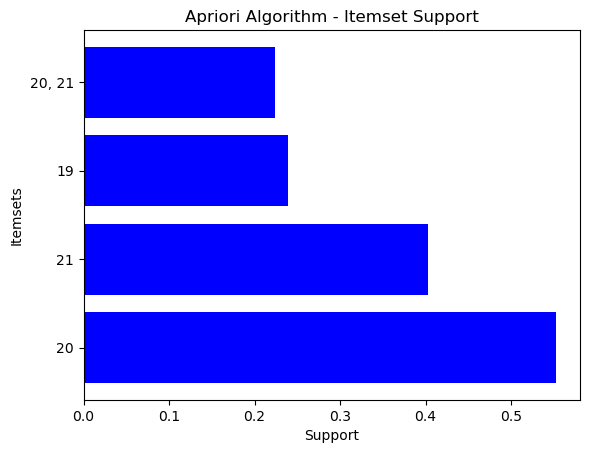

The patient is not compliant for the hours: 20, with a support of 0.5522388059701493.
The patient is not compliant for the hours: 21, with a support of 0.40298507462686567.
The patient is not compliant for the hours: 19, with a support of 0.23880597014925373.


In [20]:
# Sort the results by support in descending order
results = most_frequent_itemsets_hours.sort_values(by='support', ascending=False)

# Modify the itemsets column to remove 'frozenset' and display cleaner visualization
results['itemsets'] = results['itemsets'].apply(lambda x: ", ".join(str(item) for item in x))

# Visualize the support values
plt.barh(range(len(results)), results['support'], color='blue')
plt.yticks(range(len(results)), results['itemsets'])
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Apriori Algorithm - Itemset Support')
plt.show()

# Print the top three itemsets
for index, row in results.head(3).iterrows():
    print(f"The patient is not compliant for the hours: {row['itemsets']}, with a support of {row['support']}.")

### Similarly showing at what particular time of day patient is least compliant

In [37]:
# Convert the transaction data to a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions_of_time_of_day).transform(transactions_of_time_of_day)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [38]:
# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets_day = apriori(df, min_support=0.2, use_colnames=True)


In [39]:
# Sort the frequent itemsets by support in descending order
frequent_itemsets_day = frequent_itemsets_day.sort_values(by='support', ascending=False)


In [40]:
# Get the most frequent itemsets
frequent_itemsets_day = frequent_itemsets_day.head(15)  # Adjust the number as needed

print(frequent_itemsets_day)

     support                              itemsets
1   0.773585                             (Evening)
0   0.490566                           (Afternoon)
2   0.490566                             (Morning)
4   0.415094                  (Evening, Afternoon)
5   0.396226                  (Afternoon, Morning)
3   0.377358                               (Night)
7   0.377358                    (Evening, Morning)
9   0.377358                      (Morning, Night)
10  0.339623         (Evening, Afternoon, Morning)
6   0.320755                    (Afternoon, Night)
12  0.320755           (Afternoon, Morning, Night)
8   0.283019                      (Evening, Night)
13  0.283019             (Evening, Morning, Night)
11  0.264151           (Evening, Afternoon, Night)
14  0.264151  (Evening, Afternoon, Morning, Night)


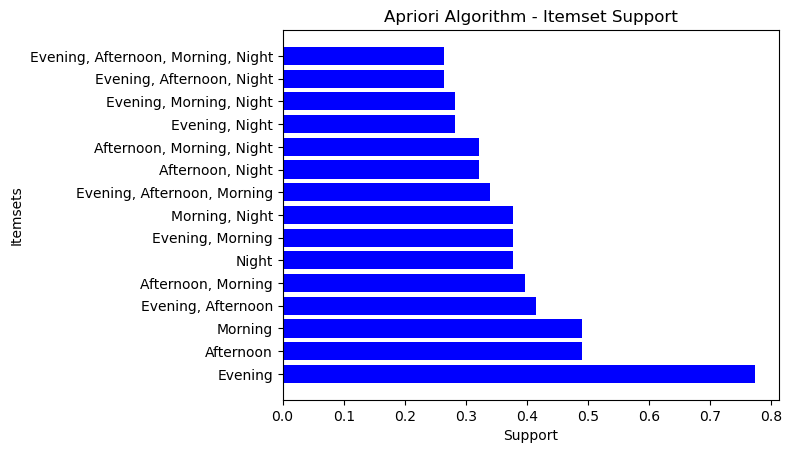

The patient is least compliant during the following time of day : Evening, with a support of 0.7735849056603774.


In [42]:
# Sort the results by support in decending order
results = frequent_itemsets_day.sort_values(by='support',ascending=False)

# Modify the itemsets column to remove 'frozenset' and display cleaner visualization
results['itemsets'] = results['itemsets'].apply(lambda x: ", ".join(str(item) for item in x))

# Visualize the support values
plt.barh(range(len(results)), results['support'], color='blue')
plt.yticks(range(len(results)), results['itemsets'])
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Apriori Algorithm - Itemset Support')
plt.show()

# Print the itemset with the least support
most_support_itemset = results.iloc[0]
print(f"The patient is least compliant during the following time of day : {most_support_itemset['itemsets']}, with a support of {most_support_itemset['support']}.")